In [1]:
import numpy as np
import pandas as pd
import joblib

import seaborn as sns
import matplotlib.pyplot as plt

import pickle 
from os import path

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
data = pd.read_csv('UNSW_NB15.csv')

In [3]:
data['service'].replace('-',np.nan,inplace=True)

In [4]:
data.dropna(inplace=True)

In [5]:
features = pd.read_csv('UNSW_NB15_features.csv')

In [6]:
features['Type '] = features['Type '].str.lower()

In [7]:
nominal_names  = features['Name'][features['Type ']=='nominal']
integer_names  = features['Name'][features['Type ']=='integer']
binary_names   = features['Name'][features['Type ']=='binary']
float_names    = features['Name'][features['Type ']=='float']

In [8]:
cols           = data.columns
nominal_names  = cols.intersection(nominal_names)
integer_names  = cols.intersection(integer_names)
binary_names   = cols.intersection(binary_names)
float_names    = cols.intersection(float_names)

In [9]:
for c in integer_names:
  pd.to_numeric(data[c])

In [10]:
for c in binary_names:
  pd.to_numeric(data[c])

In [11]:
for c in float_names:
  pd.to_numeric(data[c])

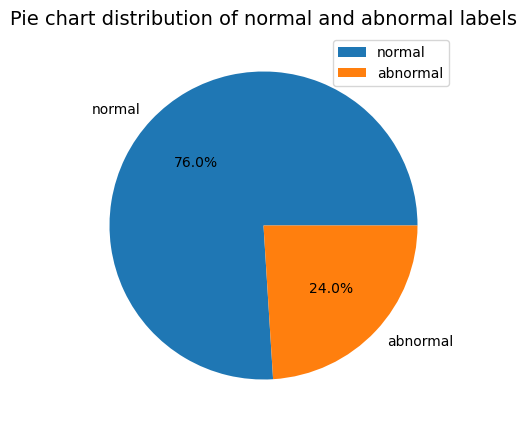

In [12]:
plt.figure(figsize=(5,5))
plt.pie(data.label.value_counts(),labels=['normal','abnormal'],autopct='%0.1f%%')
plt.title("Pie chart distribution of normal and abnormal labels",fontsize=14)
plt.legend()
plt.savefig('plot/Pie_chart_binary.png')
plt.show()

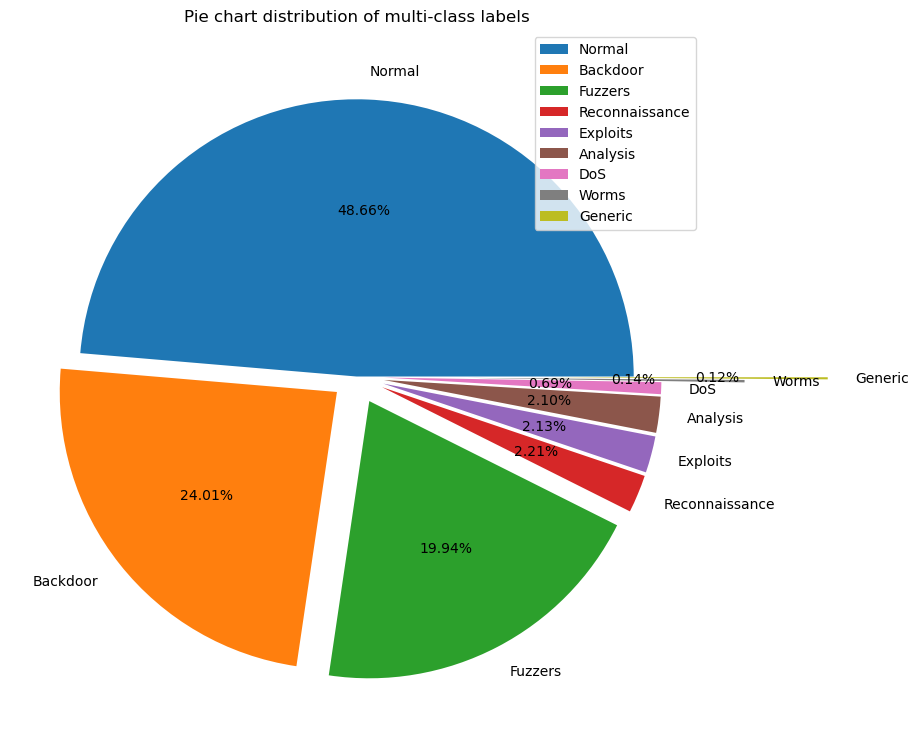

In [13]:
plt.figure(figsize=(9,9))
explode = (0, 0.09,0.1,0.1,0.1,0.1,0.1,0.4,0.7)
plt.pie(data.attack_cat.value_counts(),explode=explode,labels=data.attack_cat.unique(),autopct='%0.2f%%')
plt.title('Pie chart distribution of multi-class labels')
plt.legend(loc='best')
plt.savefig('plot/Pie_chart_multi.png')

plt.show()

In [14]:
num_col = data.select_dtypes(include='number').columns
# selecting categorical data attributes
cat_col = data.columns.difference(num_col)
# selecting categorical data attributes
cat_col = data.columns.difference(num_col)
cat_col = cat_col[1:]
cat_col

Index(['proto', 'service', 'state'], dtype='object')

In [15]:
data_cat = data[cat_col].copy()
data_cat.head()

,proto,service,state
3,tcp,ftp,FIN
11,tcp,smtp,FIN
15,udp,snmp,INT
17,tcp,http,FIN
21,tcp,http,FIN


In [16]:
data_cat = pd.get_dummies(data_cat,columns=cat_col)

In [17]:
data_cat.head()

,proto_tcp,proto_udp,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_CON,state_FIN,state_INT,state_REQ,state_RST
3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
11,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
15,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
17,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
21,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [18]:
data = pd.concat([data, data_cat],axis=1)

In [19]:
data.drop(columns=cat_col,inplace=True)

In [20]:
num_col = list(data.select_dtypes(include='number').columns)
num_col.remove('id')
num_col.remove('label')
print(num_col)

['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'proto_tcp', 'proto_udp', 'service_dhcp', 'service_dns', 'service_ftp', 'service_ftp-data', 'service_http', 'service_irc', 'service_pop3', 'service_radius', 'service_smtp', 'service_snmp', 'service_ssh', 'service_ssl', 'state_CON', 'state_FIN', 'state_INT', 'state_REQ', 'state_RST']


In [21]:
minmax_scale = MinMaxScaler(feature_range=(0, 1))
def normalization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = minmax_scale.fit_transform(arr.reshape(len(arr),1))
  return df

In [22]:
data = normalization(data.copy(),num_col)

In [23]:
bin_label = pd.DataFrame(data.label.map(lambda x:'normal' if x==0 else 'abnormal'))

In [24]:
bin_data = data.copy()
bin_data['label'] = bin_label

In [25]:
le1 = preprocessing.LabelEncoder()
enc_label = bin_label.apply(le1.fit_transform)
bin_data['label'] = enc_label

In [26]:
le1.classes_

array(['abnormal', 'normal'], dtype=object)

In [27]:
np.save("le1_classes.npy",le1.classes_,allow_pickle=True)

In [28]:
multi_data = data.copy()
multi_label = pd.DataFrame(multi_data.attack_cat)

In [29]:
multi_data = pd.get_dummies(multi_data,columns=['attack_cat'])

In [30]:
le2 = preprocessing.LabelEncoder()
enc_label = multi_label.apply(le2.fit_transform)
multi_data['label'] = enc_label

In [31]:
le2.classes_

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Worms'], dtype=object)

In [32]:
num_col.append('label')

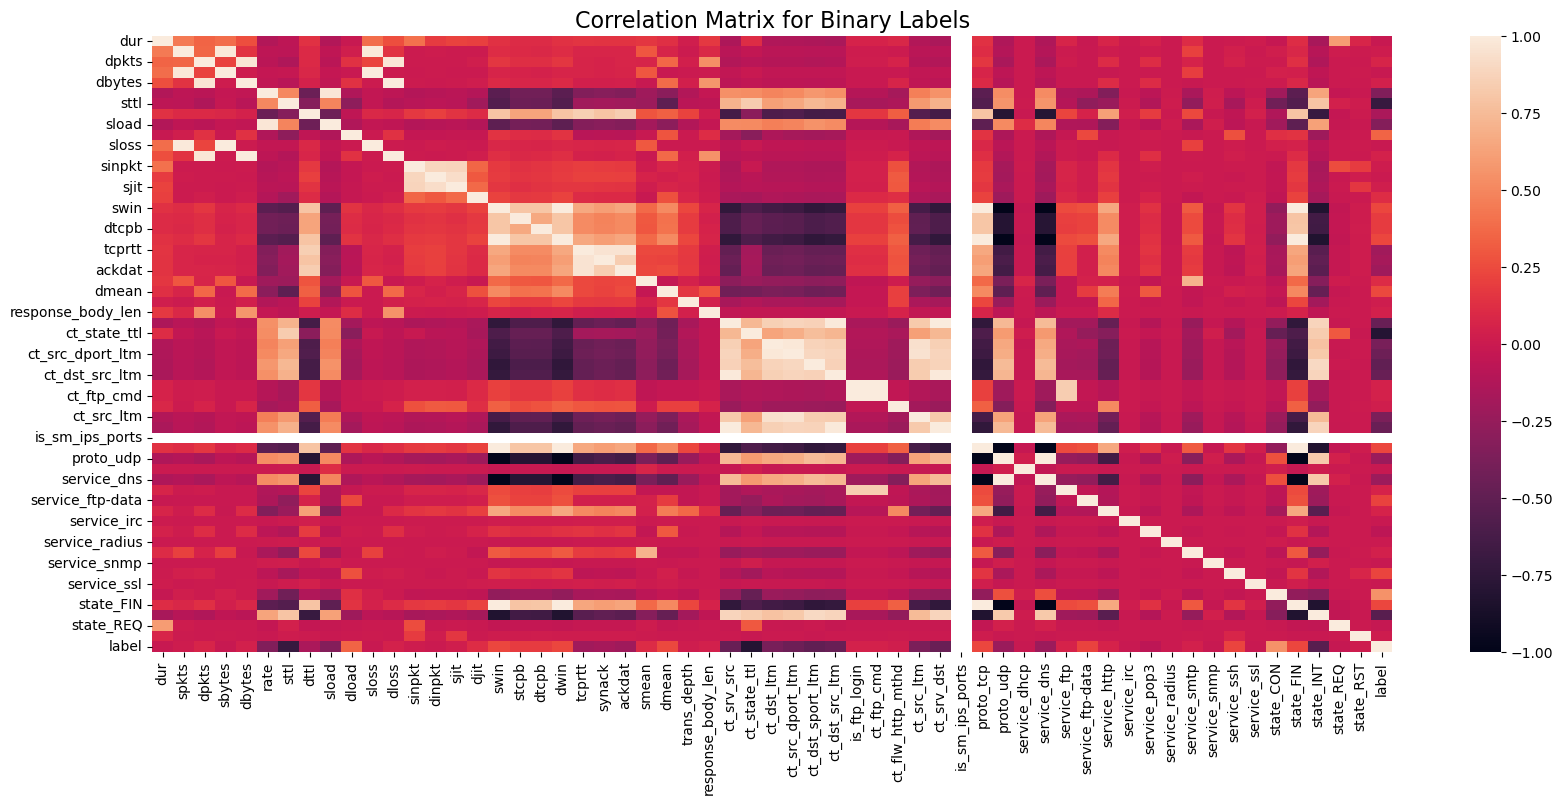

In [33]:
plt.figure(figsize=(20,8))
corr_bin = bin_data[num_col].corr()
sns.heatmap(corr_bin,vmax=1.0,annot=False)
plt.title('Correlation Matrix for Binary Labels',fontsize=16)
plt.savefig('plot/correlation_matrix_bin.png')
plt.show()

In [34]:
num_col = list(multi_data.select_dtypes(include='number').columns)

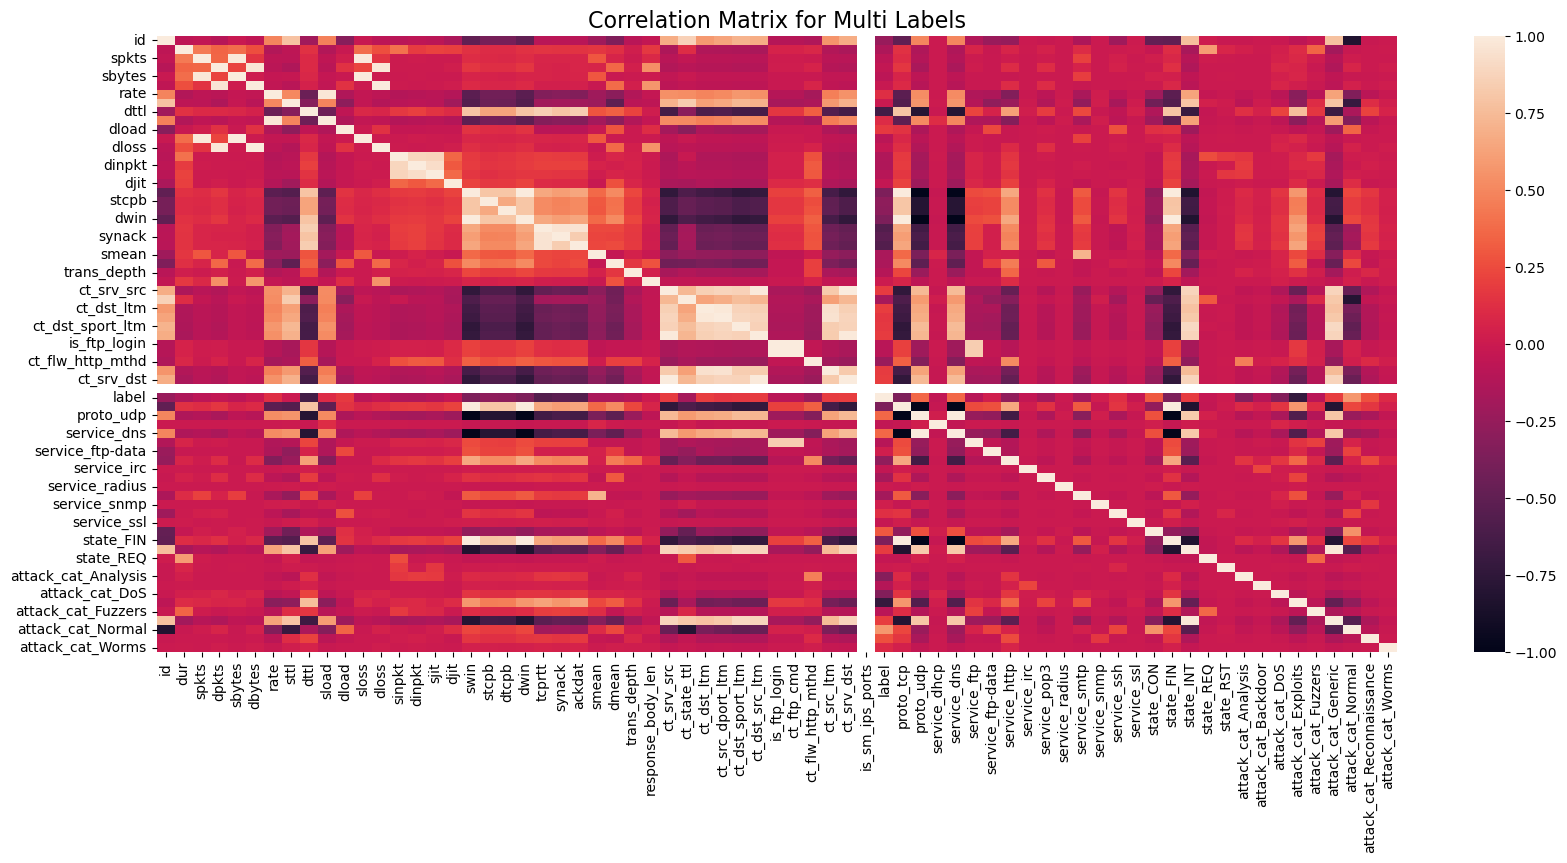

In [35]:
plt.figure(figsize=(20,8))
corr_multi = multi_data[num_col].corr()
sns.heatmap(corr_multi,vmax=1.0,annot=False)
plt.title('Correlation Matrix for Multi Labels',fontsize=16)
plt.savefig('plot/correlation_matrix_multi.png')
plt.show()

In [36]:
corr_ybin = abs(corr_bin['label'])
highest_corr_bin = corr_ybin[corr_ybin >0.3]
highest_corr_bin.sort_values(ascending=True)

sload               0.334562
dload               0.343910
rate                0.344535
ct_src_ltm          0.368486
ct_dst_ltm          0.387358
ct_src_dport_ltm    0.444874
ct_srv_dst          0.459984
ct_srv_src          0.463153
ct_dst_src_ltm      0.463735
ct_dst_sport_ltm    0.497234
state_INT           0.546631
state_CON           0.552505
sttl                0.707337
ct_state_ttl        0.801403
label               1.000000
Name: label, dtype: float64

In [37]:
bin_cols = highest_corr_bin.index
bin_cols

Index(['rate', 'sttl', 'sload', 'dload', 'ct_srv_src', 'ct_state_ttl',
       'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'ct_src_ltm', 'ct_srv_dst', 'state_CON', 'state_INT', 'label'],
      dtype='object')

In [38]:
bin_data = bin_data[bin_cols].copy()
bin_data

,rate,sttl,sload,dload,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,state_CON,state_INT,label
3,0.000014,0.138393,0.000001,0.000150,0.000000,0.166667,0.02,0.00,0.000000,0.039216,0.016949,0.000000,0.0,0.0,1
11,0.000043,0.138393,0.000092,0.000364,0.019608,0.166667,0.00,0.00,0.000000,0.019608,0.000000,0.000000,0.0,0.0,1
15,0.500000,0.995536,0.119792,0.000000,0.000000,0.333333,0.00,0.00,0.000000,0.058824,0.016949,0.000000,0.0,1.0,1
17,0.000043,0.138393,0.000007,0.000869,0.039216,0.166667,0.00,0.00,0.000000,0.019608,0.000000,0.039216,0.0,0.0,1
21,0.000044,0.995536,0.000009,0.000236,0.098039,0.166667,0.00,0.00,0.000000,0.000000,0.016949,0.039216,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175335,0.166667,0.995536,0.032986,0.000000,0.862745,0.333333,0.64,0.64,0.533333,0.862745,0.542373,0.862745,0.0,1.0,0
175336,0.111111,0.995536,0.021991,0.000000,0.450980,0.333333,0.46,0.46,0.400000,0.450980,0.389831,0.450980,0.0,1.0,0
175338,0.111111,0.995536,0.021991,0.000000,0.215686,0.333333,0.04,0.04,0.066667,0.235294,0.033898,0.215686,0.0,1.0,0
175339,0.111111,0.995536,0.021991,0.000000,0.568627,0.333333,0.58,0.58,0.433333,0.568627,0.491525,0.568627,0.0,1.0,0


In [39]:
bin_data.to_csv('csvfiles/bin_data.csv')

In [40]:
corr_ymulti = abs(corr_multi['label'])
highest_corr_multi = corr_ymulti[corr_ymulti >0.3]
highest_corr_multi.sort_values(ascending=True)

state_CON              0.302853
attack_cat_Analysis    0.326209
attack_cat_DoS         0.339669
state_FIN              0.361750
proto_udp              0.364393
swin                   0.364393
dwin                   0.364393
proto_tcp              0.364393
service_dns            0.365346
synack                 0.524027
ackdat                 0.570098
tcprtt                 0.570205
attack_cat_Normal      0.570858
dttl                   0.646589
attack_cat_Exploits    0.719733
label                  1.000000
Name: label, dtype: float64

In [41]:
multi_cols = highest_corr_multi.index
multi_cols

Index(['dttl', 'swin', 'dwin', 'tcprtt', 'synack', 'ackdat', 'label',
       'proto_tcp', 'proto_udp', 'service_dns', 'state_CON', 'state_FIN',
       'attack_cat_Analysis', 'attack_cat_DoS', 'attack_cat_Exploits',
       'attack_cat_Normal'],
      dtype='object')

In [42]:
multi_data = multi_data[multi_cols].copy()

In [43]:
multi_data.to_csv('csvfiles/multi_data.csv')

In [44]:
X = bin_data.drop(columns=['label'],axis=1)
Y = bin_data['label']

In [45]:
import pandas as pd                                                  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor
import joblib

In [46]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.20, random_state=50)

In [47]:
lr_bin = LinearRegression(normalize=False)
lr_bin.fit(X_train, y_train)

R:\annaconda\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


LinearRegression(normalize=False)

In [58]:
y_pred = lr_bin.predict(X_test)

In [59]:
round = lambda x:1 if x>0.6 else 0
vfunc = np.vectorize(round)
y_pred = vfunc(y_pred)

In [60]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred)*100)

Mean Absolute Error -  0.021927933477055742
Mean Squared Error -  0.021927933477055742
Root Mean Squared Error -  0.1480808342664767
R2 Score -  88.20923868071647
Accuracy -  97.80720665229443


In [61]:
cls_report= classification_report(y_true=y_test, y_pred=y_pred,target_names=le1.classes_)

In [62]:
print(cls_report)

              precision    recall  f1-score   support

    abnormal       0.97      1.00      0.99     12326
      normal       0.99      0.91      0.95      3909

    accuracy                           0.98     16235
   macro avg       0.98      0.96      0.97     16235
weighted avg       0.98      0.98      0.98     16235



In [63]:
joblib.dump(lr_bin, "lr_bin.joblib")

['lr_bin.joblib']

In [55]:
lr_bin_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
lr_bin_df.to_csv('dataofreal&predicted/lr_real_pred_bin.csv')
lr_bin_df

,Actual,Predicted
159889,0,0
125506,0,0
158979,0,0
8148,1,1
39918,1,1
...,...,...
68470,0,0
159674,0,0
171321,0,0
125777,0,0


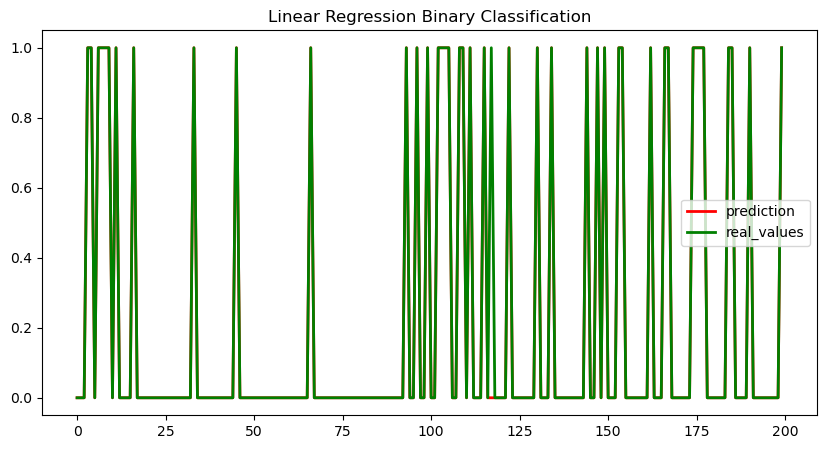

In [56]:
plt.figure(figsize=(10,5))
plt.plot(y_pred[:200], label="prediction", linewidth=2.0,color='red')
plt.plot(y_test[:200].values, label="real_values", linewidth=2.0,color='green')
plt.legend(loc="best")
plt.title("Linear Regression Binary Classification")
plt.savefig('plot/lr_real_pred_bin.png')
plt.show()

In [58]:
logr_bin = LogisticRegression(random_state=123, max_iter=5000)
logr_bin

LogisticRegression(max_iter=5000, random_state=123)

In [59]:
logr_bin.fit(X_train,y_train)

LogisticRegression(max_iter=5000, random_state=123)

In [60]:
y_pred = logr_bin.predict(X_test)

In [61]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred)*100)

Mean Absolute Error -  0.02198952879581152
Mean Squared Error -  0.02198952879581152
Root Mean Squared Error -  0.1482886671186019
R2 Score -  88.17947258428785
Accuracy -  97.80104712041884


In [62]:
cls_report= classification_report(y_true=y_test, y_pred=y_pred,target_names=le1.classes_)
print(cls_report)

              precision    recall  f1-score   support

    abnormal       0.97      1.00      0.99     12326
      normal       0.99      0.91      0.95      3909

    accuracy                           0.98     16235
   macro avg       0.98      0.96      0.97     16235
weighted avg       0.98      0.98      0.98     16235



In [63]:
logr_bin_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
logr_bin_df.to_csv('dataofreal&predicted/logr_real_pred_bin.csv')
logr_bin_df

,Actual,Predicted
159889,0,0
125506,0,0
158979,0,0
8148,1,1
39918,1,1
...,...,...
68470,0,0
159674,0,0
171321,0,0
125777,0,0


,Actual,Predicted
159889,0,0
125506,0,0
158979,0,0
8148,1,1
39918,1,1
...,...,...
68470,0,0
159674,0,0
171321,0,0
125777,0,0


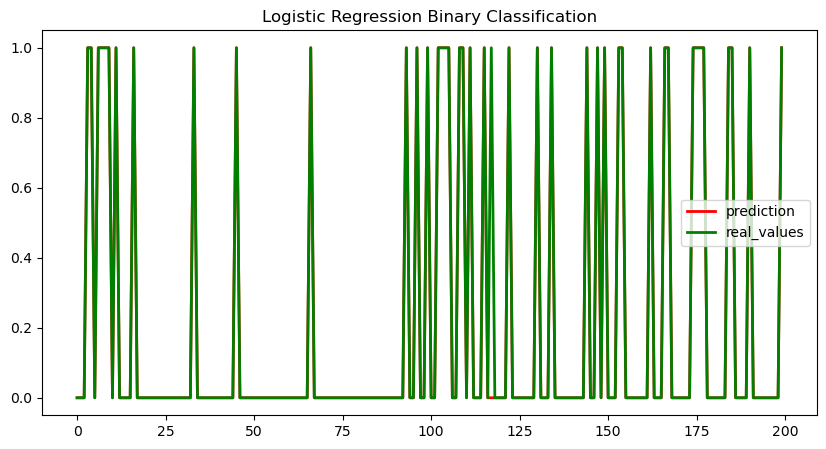

In [66]:
plt.figure(figsize=(10,5))
plt.plot(y_pred[:200], label="prediction", linewidth=2.0,color='red')
plt.plot(y_test[:200].values, label="real_values", linewidth=2.0,color='green')
plt.legend(loc="best")
plt.title("Logistic Regression Binary Classification")
plt.savefig('plot/logr_real_pred_bin.png')
plt.show()

In [67]:
lsvm_bin = SVC(kernel='linear',gamma='auto') 
lsvm_bin.fit(X_train,y_train)

SVC(gamma='auto', kernel='linear')

In [68]:
y_pred = lsvm_bin.predict(X_test)

In [69]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred)*100)

Mean Absolute Error -  0.021496766245765322
Mean Squared Error -  0.021496766245765322
Root Mean Squared Error -  0.1466177555610688
R2 Score -  88.45167193436498
Accuracy -  97.85032337542347


In [70]:
cls_report= classification_report(y_true=y_test, y_pred=y_pred,target_names=le1.classes_)
print(cls_report)

              precision    recall  f1-score   support

    abnormal       0.97      1.00      0.99     12326
      normal       1.00      0.91      0.95      3909

    accuracy                           0.98     16235
   macro avg       0.98      0.96      0.97     16235
weighted avg       0.98      0.98      0.98     16235



In [71]:
lsvm_bin_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
lsvm_bin_df.to_csv('dataofreal&predicted/lsvm_real_pred_bin.csv')
lsvm_bin_df

,Actual,Predicted
159889,0,0
125506,0,0
158979,0,0
8148,1,1
39918,1,1
...,...,...
68470,0,0
159674,0,0
171321,0,0
125777,0,0


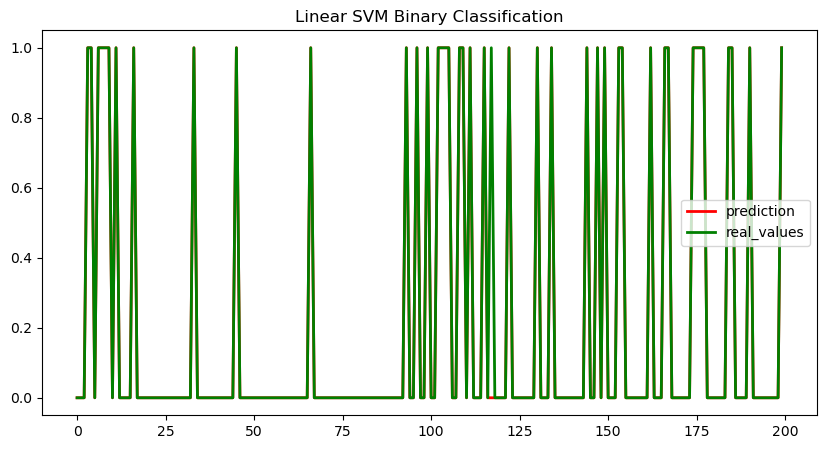

In [72]:
plt.figure(figsize=(10,5))
plt.plot(y_pred[:200], label="prediction", linewidth=2.0,color='red')
plt.plot(y_test[:200].values, label="real_values", linewidth=2.0,color='green')
plt.legend(loc="best")
plt.title("Linear SVM Binary Classification")
plt.savefig('plot/lsvm_real_pred_bin.png')
plt.show()

In [73]:
knn_bin=KNeighborsClassifier(n_neighbors=5)
knn_bin.fit(X_train,y_train)

KNeighborsClassifier()

In [74]:
y_pred = knn_bin.predict(X_test)

R:\annaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [75]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred)*100)

Mean Absolute Error -  0.016938712657838004
Mean Squared Error -  0.016938712657838004
Root Mean Squared Error -  0.13014880966738807
R2 Score -  90.74435871039374
Accuracy -  98.3061287342162


In [76]:
cls_report= classification_report(y_true=y_test, y_pred=y_pred,target_names=le1.classes_)
print(cls_report)

              precision    recall  f1-score   support

    abnormal       0.99      0.99      0.99     12326
      normal       0.97      0.96      0.96      3909

    accuracy                           0.98     16235
   macro avg       0.98      0.97      0.98     16235
weighted avg       0.98      0.98      0.98     16235



In [77]:
knn_bin_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
knn_bin_df.to_csv('dataofreal&predicted/knn_real_pred_bin.csv')
knn_bin_df

,Actual,Predicted
159889,0,0
125506,0,0
158979,0,0
8148,1,1
39918,1,1
...,...,...
68470,0,0
159674,0,0
171321,0,0
125777,0,0


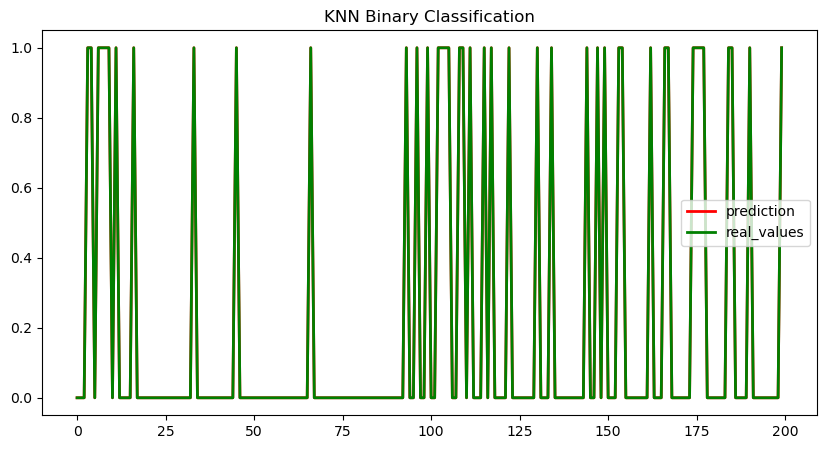

In [78]:
plt.figure(figsize=(10,5))
plt.plot(y_pred[:200], label="prediction", linewidth=2.0,color='red')
plt.plot(y_test[:200].values, label="real_values", linewidth=2.0,color='green')
plt.legend(loc="best")
plt.title("KNN Binary Classification")
plt.savefig('plot/knn_real_pred_bin.png')
plt.show()

In [79]:
rf_bin = RandomForestClassifier(random_state=123)
rf_bin.fit(X_train,y_train)

RandomForestClassifier(random_state=123)

In [80]:
y_pred = rf_bin.predict(X_test)

In [81]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred)*100)

Mean Absolute Error -  0.013550970126270403
Mean Squared Error -  0.013550970126270403
Root Mean Squared Error -  0.1164086342427846
R2 Score -  92.59509512345335
Accuracy -  98.64490298737296


In [82]:
cls_report= classification_report(y_true=y_test, y_pred=y_pred,target_names=le1.classes_)
print(cls_report)

              precision    recall  f1-score   support

    abnormal       0.99      0.99      0.99     12326
      normal       0.98      0.96      0.97      3909

    accuracy                           0.99     16235
   macro avg       0.98      0.98      0.98     16235
weighted avg       0.99      0.99      0.99     16235



In [83]:
rf_bin_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
rf_bin_df.to_csv('dataofreal&predicted/rf_real_pred_bin.csv')
rf_bin_df

,Actual,Predicted
159889,0,0
125506,0,0
158979,0,0
8148,1,1
39918,1,1
...,...,...
68470,0,0
159674,0,0
171321,0,0
125777,0,0


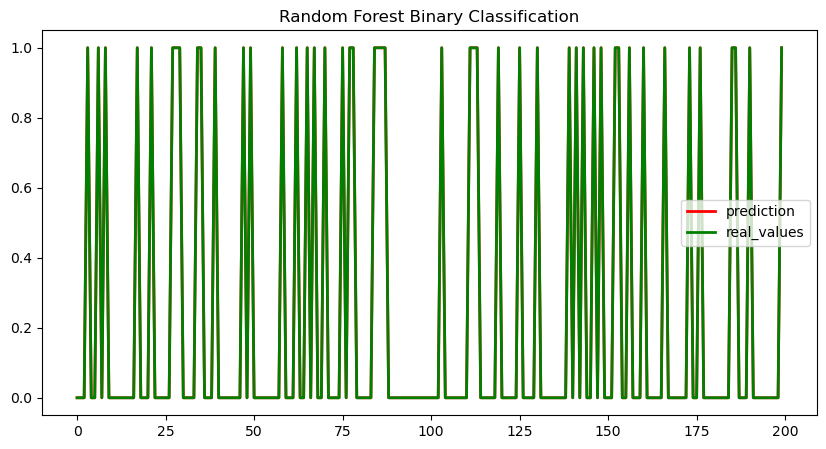

In [84]:
plt.figure(figsize=(10,5))
plt.plot(y_pred[200:400], label="prediction", linewidth=2.0,color='red')
plt.plot(y_test[200:400].values, label="real_values", linewidth=2.0,color='green')
plt.legend(loc="best")
plt.title("Random Forest Binary Classification")
plt.savefig('plot/rf_real_pred_bin.png')
plt.show()

In [85]:
dt_bin = DecisionTreeClassifier(random_state=123)
dt_bin.fit(X_train,y_train)

DecisionTreeClassifier(random_state=123)

In [86]:
y_pred = dt_bin.predict(X_test)

In [87]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred)*100)

Mean Absolute Error -  0.019094548814290114
Mean Squared Error -  0.019094548814290114
Root Mean Squared Error -  0.13818302650575473
R2 Score -  89.55757103838098
Accuracy -  98.09054511857099


In [88]:
cls_report= classification_report(y_true=y_test, y_pred=y_pred,target_names=le1.classes_)
print(cls_report)

              precision    recall  f1-score   support

    abnormal       0.99      0.99      0.99     12326
      normal       0.96      0.97      0.96      3909

    accuracy                           0.98     16235
   macro avg       0.97      0.98      0.97     16235
weighted avg       0.98      0.98      0.98     16235



In [89]:
dt_bin_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
dt_bin_df.to_csv('dataofreal&predicted/dt_real_pred_bin.csv')
dt_bin_df

,Actual,Predicted
159889,0,0
125506,0,0
158979,0,0
8148,1,1
39918,1,1
...,...,...
68470,0,0
159674,0,0
171321,0,0
125777,0,0


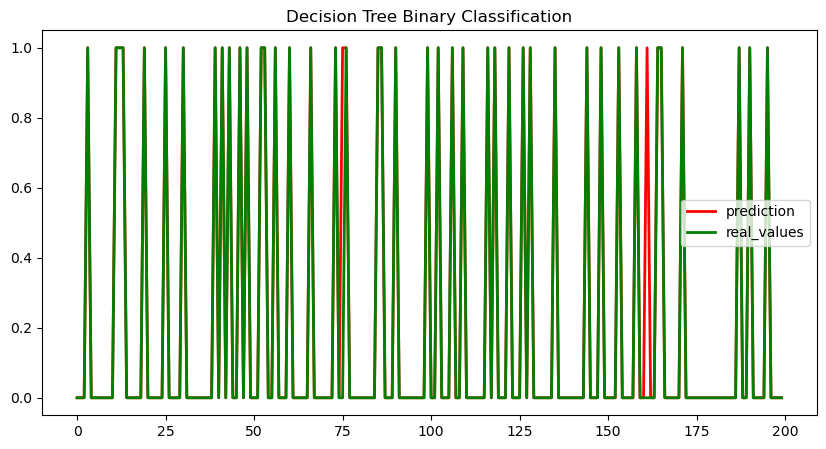

In [91]:
plt.figure(figsize=(10,5))
plt.plot(y_pred[300:500], label="prediction", linewidth=2.0,color='red')
plt.plot(y_test[300:500].values, label="real_values", linewidth=2.0,color='green')
plt.legend(loc="best")
plt.title("Decision Tree Binary Classification")
plt.savefig('plot/dt_real_pred_bin.png')
plt.show()

In [92]:
X = multi_data.drop(columns=['label'],axis=1)
Y = multi_data['label']

In [93]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.30, random_state=100)

In [94]:
lr_multi = LinearRegression(normalize=False)
lr_multi.fit(X_train, y_train)

R:\annaconda\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


LinearRegression(normalize=False)

In [95]:
y_pred = lr_multi.predict(X_test)

In [96]:
for i in range(len(y_pred)):
  y_pred[i] = int(round(y_pred[i]))

In [97]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred)*100)

Mean Absolute Error -  3.765234888304862
Mean Squared Error -  15.603851839684625
Root Mean Squared Error -  3.9501711152410377
R2 Score -  3.9127682233939476
Accuracy -  0.8130749014454665


In [98]:
print(classification_report(y_test, y_pred,target_names=le2.classes_))

                precision    recall  f1-score   support

      Analysis       1.00      1.00      1.00       166
      Backdoor       0.00      1.00      0.00        32
           DoS       0.00      0.00      0.00       521
      Exploits       0.00      0.00      0.00      4900
       Fuzzers       0.00      0.00      0.00       508
       Generic       0.00      0.00      0.00     11839
        Normal       0.00      0.00      0.00      5855
Reconnaissance       0.00      0.00      0.00       502
         Worms       0.00      0.00      0.00        29

      accuracy                           0.01     24352
     macro avg       0.11      0.22      0.11     24352
  weighted avg       0.01      0.01      0.01     24352



R:\annaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
R:\annaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
R:\annaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [99]:
lr_multi_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
lr_multi_df.to_csv('dataofreal&predicted/lr_real_pred_multi.csv')
lr_multi_df

,Actual,Predicted
22650,6,1.0
27815,6,1.0
49033,3,1.0
156811,5,1.0
136878,5,1.0
...,...,...
94950,4,1.0
148684,5,1.0
12788,6,1.0
81439,3,1.0


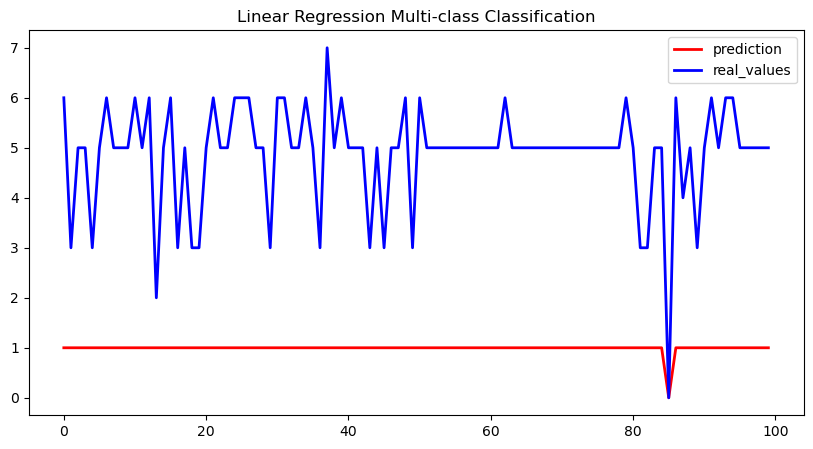

In [101]:
plt.figure(figsize=(10,5))
plt.plot(y_pred[100:200], label="prediction", linewidth=2.0,color='red')
plt.plot(y_test[100:200].values, label="real_values", linewidth=2.0,color='blue')
plt.legend(loc="best")
plt.title("Linear Regression Multi-class Classification")
plt.savefig('plot/lr_real_pred_multi.png')
plt.show()

In [102]:
logr_multi = LogisticRegression(random_state=123, max_iter=5000,solver='newton-cg',multi_class='multinomial')
logr_multi.fit(X_train,y_train)

LogisticRegression(max_iter=5000, multi_class='multinomial', random_state=123,
                   solver='newton-cg')

In [103]:
y_pred = logr_multi.predict(X_test)

In [104]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred)*100)

Mean Absolute Error -  0.060077201051248356
Mean Squared Error -  0.18056011826544022
Root Mean Squared Error -  0.42492366169165047
R2 Score -  87.87674567880146
Accuracy -  97.58952036793693


In [105]:
print(classification_report(y_test, y_pred,target_names=le2.classes_))

                precision    recall  f1-score   support

      Analysis       1.00      1.00      1.00       166
      Backdoor       0.00      0.00      0.00        32
           DoS       1.00      1.00      1.00       521
      Exploits       1.00      1.00      1.00      4900
       Fuzzers       0.56      0.42      0.48       508
       Generic       0.99      0.99      0.99     11839
        Normal       1.00      1.00      1.00      5855
Reconnaissance       0.54      0.76      0.63       502
         Worms       0.00      0.00      0.00        29

      accuracy                           0.98     24352
     macro avg       0.68      0.69      0.68     24352
  weighted avg       0.97      0.98      0.97     24352



R:\annaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
R:\annaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
R:\annaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [106]:
logr_multi_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
logr_multi_df.to_csv('dataofreal&predicted/logr_real_pred_multi.csv')
logr_multi_df

,Actual,Predicted
22650,6,6
27815,6,6
49033,3,3
156811,5,5
136878,5,5
...,...,...
94950,4,5
148684,5,5
12788,6,6
81439,3,3


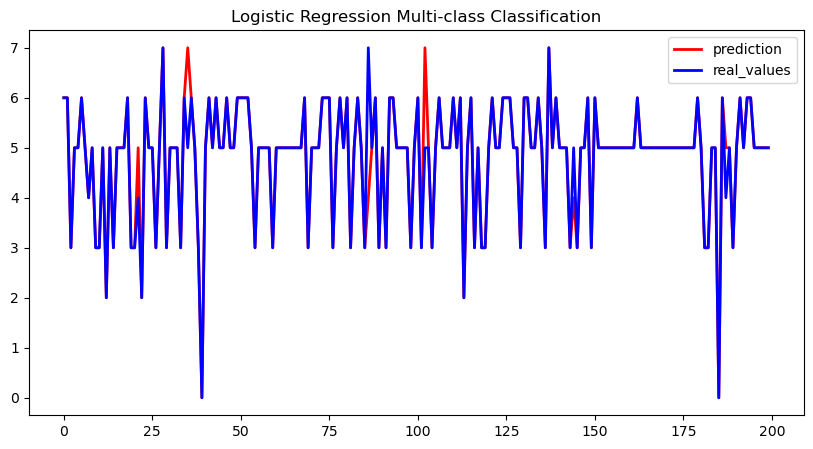

In [108]:
plt.figure(figsize=(10,5))
plt.plot(y_pred[:200], label="prediction", linewidth=2.0,color='red')
plt.plot(y_test[:200].values, label="real_values", linewidth=2.0,color='blue')
plt.legend(loc="best")
plt.title("Logistic Regression Multi-class Classification")
plt.savefig('plot/logr_real_pred_multi.png')
plt.show()

In [109]:
lsvm_multi = SVC(kernel='linear',gamma='auto')
lsvm_multi.fit(X_train,y_train) 

SVC(gamma='auto', kernel='linear')

In [110]:
y_pred = lsvm_multi.predict(X_test)

In [111]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred)*100)

Mean Absolute Error -  0.059912943495400786
Mean Squared Error -  0.17941031537450722
Root Mean Squared Error -  0.42356854861345317
R2 Score -  87.93449282205455
Accuracy -  97.59362680683311


In [112]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred)*100)

Mean Absolute Error -  0.059912943495400786
Mean Squared Error -  0.17941031537450722
Root Mean Squared Error -  0.42356854861345317
R2 Score -  87.93449282205455
Accuracy -  97.59362680683311


In [113]:
lsvm_multi_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
lsvm_multi_df.to_csv('dataofreal&predicted/lsvm_real_pred_multi.csv')
lsvm_multi_df

,Actual,Predicted
22650,6,6
27815,6,6
49033,3,3
156811,5,5
136878,5,5
...,...,...
94950,4,5
148684,5,5
12788,6,6
81439,3,3


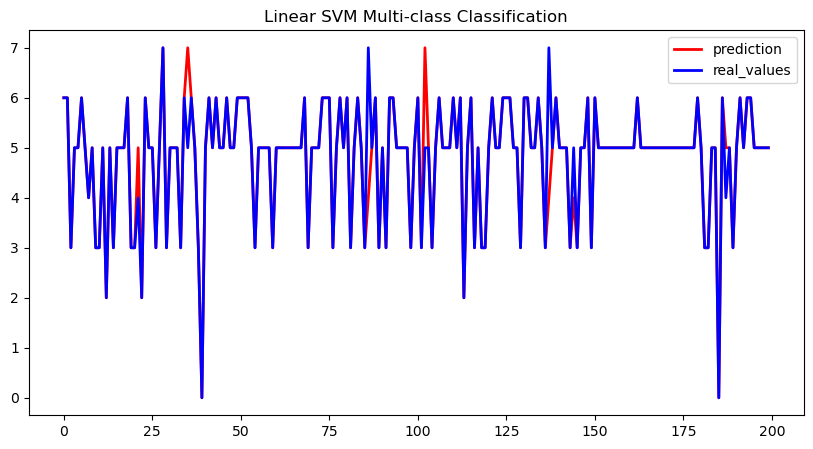

In [115]:
plt.figure(figsize=(10,5))
plt.plot(y_pred[:200], label="prediction", linewidth=2.0,color='red')
plt.plot(y_test[:200].values, label="real_values", linewidth=2.0,color='blue')
plt.legend(loc="best")
plt.title("Linear SVM Multi-class Classification")
plt.savefig('plot/lsvm_real_pred_multi.png')
plt.show()

In [116]:
knn_multi = KNeighborsClassifier(n_neighbors=5)
knn_multi.fit(X_train,y_train)

KNeighborsClassifier()

In [117]:
y_pred = knn_multi.predict(X_test)

R:\annaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [118]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred)*100)

Mean Absolute Error -  0.06492279894875164
Mean Squared Error -  0.19370072273324573
Root Mean Squared Error -  0.44011444276829376
R2 Score -  86.95611180660822
Accuracy -  97.37598554533508


In [119]:
print(classification_report(y_test, y_pred,target_names=le2.classes_))

                precision    recall  f1-score   support

      Analysis       1.00      1.00      1.00       166
      Backdoor       0.00      0.00      0.00        32
           DoS       1.00      1.00      1.00       521
      Exploits       1.00      1.00      1.00      4900
       Fuzzers       0.48      0.52      0.50       508
       Generic       0.99      0.99      0.99     11839
        Normal       1.00      1.00      1.00      5855
Reconnaissance       0.56      0.54      0.55       502
         Worms       0.00      0.00      0.00        29

      accuracy                           0.97     24352
     macro avg       0.67      0.67      0.67     24352
  weighted avg       0.97      0.97      0.97     24352



In [120]:
knn_multi_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
knn_multi_df.to_csv('dataofreal&predicted/knn_real_pred_multi.csv')
knn_multi_df

,Actual,Predicted
22650,6,6
27815,6,6
49033,3,3
156811,5,5
136878,5,5
...,...,...
94950,4,5
148684,5,5
12788,6,6
81439,3,3


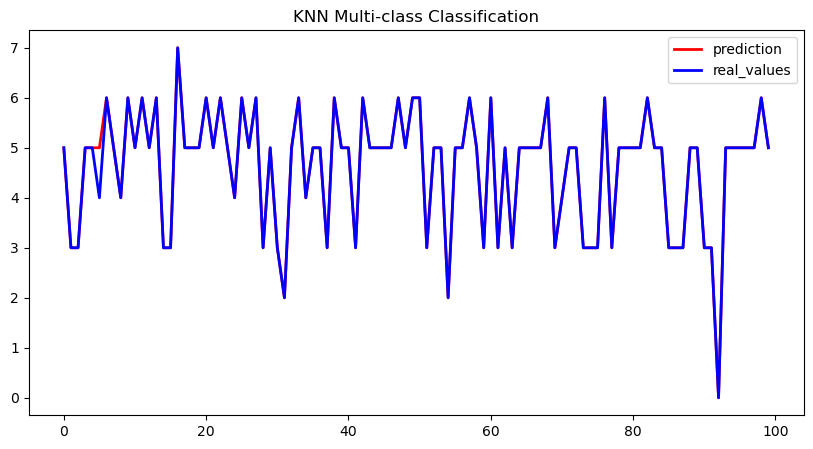

In [122]:
plt.figure(figsize=(10,5))
plt.plot(y_pred[400:500], label="prediction", linewidth=2.0,color='red')
plt.plot(y_test[400:500].values, label="real_values", linewidth=2.0,color='blue')
plt.legend(loc="best")
plt.title("KNN Multi-class Classification")
plt.savefig('plot/knn_real_pred_multi.png')
plt.show()

In [123]:
rf_multi = RandomForestClassifier(random_state=50)
rf_multi.fit(X_train,y_train)

RandomForestClassifier(random_state=50)

In [124]:
y_pred = rf_multi.predict(X_test)

In [125]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred)*100)

Mean Absolute Error -  0.06611366622864652
Mean Squared Error -  0.1985052562417871
Root Mean Squared Error -  0.4455392869790352
R2 Score -  86.6379909424011
Accuracy -  97.31849540078844


In [126]:
print(classification_report(y_test, y_pred,target_names=le2.classes_))

                precision    recall  f1-score   support

      Analysis       1.00      1.00      1.00       166
      Backdoor       0.08      0.03      0.05        32
           DoS       1.00      1.00      1.00       521
      Exploits       1.00      1.00      1.00      4900
       Fuzzers       0.49      0.43      0.46       508
       Generic       0.99      0.99      0.99     11839
        Normal       1.00      1.00      1.00      5855
Reconnaissance       0.54      0.60      0.57       502
         Worms       0.12      0.07      0.09        29

      accuracy                           0.97     24352
     macro avg       0.69      0.68      0.68     24352
  weighted avg       0.97      0.97      0.97     24352



In [127]:
rf_multi_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
rf_multi_df.to_csv('dataofreal&predicted/rf_real_pred_multi.csv')
rf_multi_df

,Actual,Predicted
22650,6,6
27815,6,6
49033,3,3
156811,5,5
136878,5,5
...,...,...
94950,4,5
148684,5,5
12788,6,6
81439,3,3


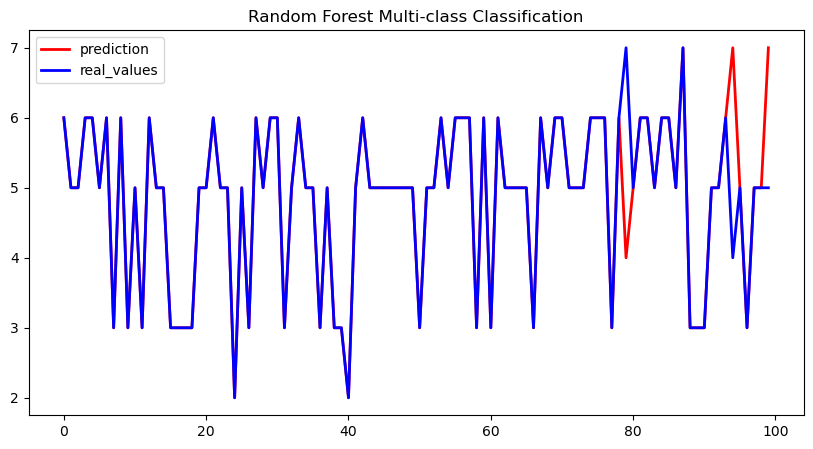

In [129]:
plt.figure(figsize=(10,5))
plt.plot(y_pred[500:600], label="prediction", linewidth=2.0,color='red')
plt.plot(y_test[500:600].values, label="real_values", linewidth=2.0,color='blue')
plt.legend(loc="best")
plt.title("Random Forest Multi-class Classification")
plt.savefig('plot/rf_real_pred_multi.png')
plt.show()

In [130]:
dt_multi = DecisionTreeClassifier(random_state=123)
dt_multi.fit(X_train,y_train)

DecisionTreeClassifier(random_state=123)

In [131]:
dt_multi = DecisionTreeClassifier(random_state=123)
dt_multi.fit(X_train,y_train)

DecisionTreeClassifier(random_state=123)

In [132]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred)*100)

Mean Absolute Error -  0.06611366622864652
Mean Squared Error -  0.1985052562417871
Root Mean Squared Error -  0.4455392869790352
R2 Score -  86.6379909424011
Accuracy -  97.31849540078844


In [133]:
print(classification_report(y_test, y_pred,target_names=le2.classes_))

                precision    recall  f1-score   support

      Analysis       1.00      1.00      1.00       166
      Backdoor       0.08      0.03      0.05        32
           DoS       1.00      1.00      1.00       521
      Exploits       1.00      1.00      1.00      4900
       Fuzzers       0.49      0.43      0.46       508
       Generic       0.99      0.99      0.99     11839
        Normal       1.00      1.00      1.00      5855
Reconnaissance       0.54      0.60      0.57       502
         Worms       0.12      0.07      0.09        29

      accuracy                           0.97     24352
     macro avg       0.69      0.68      0.68     24352
  weighted avg       0.97      0.97      0.97     24352



In [134]:
dt_multi_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
dt_multi_df.to_csv('dataofreal&predicted/dt_real_pred_multi.csv')
dt_multi_df

,Actual,Predicted
22650,6,6
27815,6,6
49033,3,3
156811,5,5
136878,5,5
...,...,...
94950,4,5
148684,5,5
12788,6,6
81439,3,3


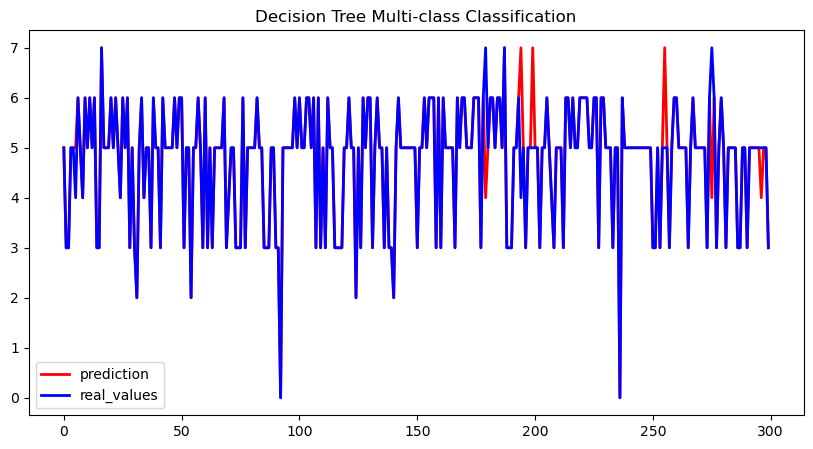

In [135]:
plt.figure(figsize=(10,5))
plt.plot(y_pred[400:700], label="prediction", linewidth=2.0,color='red')
plt.plot(y_test[400:700].values, label="real_values", linewidth=2.0,color='blue')
plt.legend(loc="best")
plt.title("Decision Tree Multi-class Classification")
plt.savefig('plot/dt_real_pred_multi.png')
plt.show()